


# Segmenting and Clustering Neighborhoods in Toronto
    
# Introduction
    
In this notebook is presented the segmentation and clustering of the Postal codes division of the city of Toronto in the province of Ontario, Canada, extracted from "List of postal codes of Canada: M" in Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). The Foursquare API was used to find the venues on each postal code zone using a radius based on the area cover by each postcode without overlapping between them and a maximum number of venues per postal code of 100. Using K-Means clustering algorithm, the postal codes were grouped based on the venues density (venues/area) and the result was showed on a map of Toronto.
    


 

    


In [1]:
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  43.76 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  31.40 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  28.52 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  31.83 MB/s


## Download and Explore Dataset

BeautifulSoup library is used to scrape the Wikipedia's article that contains the Toronto neighborhood. The neighborhood data presented in a Table on the article is parsed and stored in a list that contains each row of the table, that is the Postcode, Borough and Neighborhood name.

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neightborhood_info.append(info)
    
neightborhood_info[0:10]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned']]

#### Transform the data into a pandas dataframe

Then the neighborhood_info list is passed to pandas to create a DataFrame


In [3]:
#create a Neighborhoods dataframe
neightborhood_info[0][-1] = 'Neighborhood' # change to american spelling
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


## Explore and clean neighborhoods dataset

The data returned has missing info like "Not assigned" boroughs and neighborhoods.

In [4]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (289, 3) 

There are:
  180 Postal codes
  11 Boroughs
  209 Neighborhoods
  77 rows with Not assigned Borough
  78 rows with Not assigned Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



The rows with "Not assigned" Boroughs will be eliminated

In [5]:
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


The "Not assigned" values in the Neighborhood column will be replace with the Borough name in that cell

In [6]:
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [7]:
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (212, 3) 

There are:
  103 Postal codes
  11 Boroughs
  210 Neighborhoods


The dataframe has 103 Postal codes but it has 212 rows, because each Postal code can present more than one neighborhood (210 in total). Therefore, the dataframe should be group by the Postal code, ending with a dataframe with 103 rows.

In [8]:
group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [9]:
print('The DataFrame shape is', grouped_df.shape)

The DataFrame shape is (103, 3)


## Get Latitude and Longitude data for all the boroughs

In [10]:
!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geocoder:   1.38.1-py_0  conda-forge
    orderedset: 2.0-py35_0   conda-forge
    ratelim:    0.1.6-py35_0 conda-forge

orderedset-2.0 100% |################################| Time: 0:00:00  47.58 MB/s
ratelim-0.1.6- 100% |################################| Time: 0:00:00  12.84 MB/s
geocoder-1.38. 100% |################################| Time: 0:00:00  44.99 MB/s


In [11]:
loc = "http://cocl.us/Geospatial_data"
coordinates_df = pd.read_csv(loc)
coordinates_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postcode')

postcodes_with_coordinates_df.head(16)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [13]:
df_toronto = neighborhood_df[neighborhood_df['Borough'].str.contains('Toronto')]
df_toronto.Borough.unique()

array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'Central Toronto'], dtype=object)

With the coordinates of each postal code, a map of Toronto with markers indicating the Postcode position is generated

In [14]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

The map shows that the Postal codes are not evenly spaced, and the area cover by some of them, using a radius of 500 meters, overlaps. A different radius for each postcode results in a better venues search because that will avoid misrepresentation of the number of venues per postcode caused by too large or low radius values.

In [15]:
import matplotlib.pyplot as plt

X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

find the closest points for each postcode.

In [16]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [17]:
coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


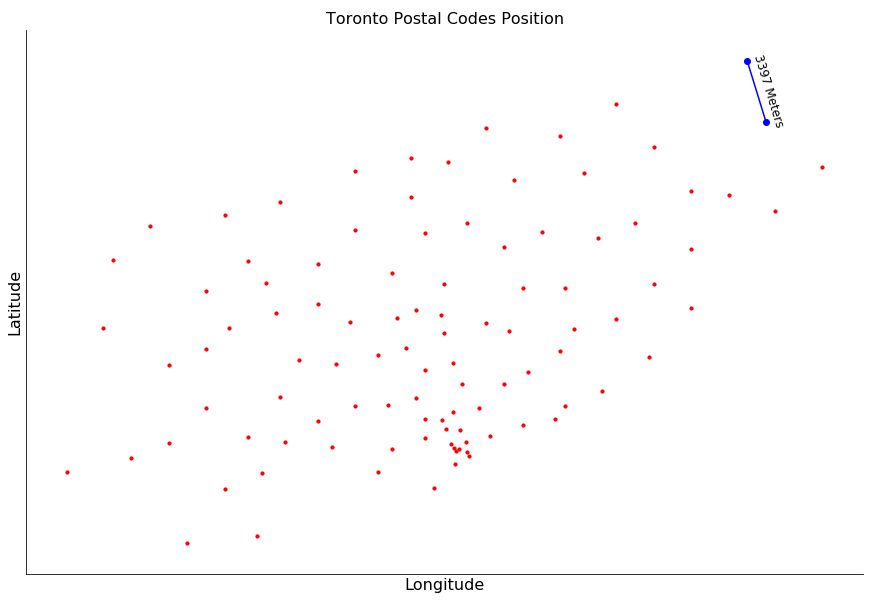

In [18]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

A distant column is added to the DataFrame and is used as the radius cover for each postcode

In [19]:
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1302.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1113.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1113.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


The map is plotted using different radius for each postal code. Now not only overlapping was avoided but more area of the city is cover, consequently, more venues are retrieved

In [20]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

## Get Venues
In order to get the venues in the perimeter of each Postal code, it is necessary to get the geographical coordinates (lat and lng) of each one of those and add them to the dataframe. The geopy library is not compatible with Canada's postcode and geocoder is an unreliable library. For that reason the coordinates are in the csv file "http://cocl.us/Geospatial_data".

In [21]:
CLIENT_ID = '4S2SWSJCB4RJUNTMOXCBRS1DJ5TBD23RSSJHX1NO2ZAEA4U1' 
CLIENT_SECRET = 'L2K1DJXYPKRXTC0LTUFLHMOQLN2MSZVQKYEI43CQASFNOFTI' 
VERSION = '20191102'

In [22]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [23]:
first_postcode = postcodes_with_coordinates_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=4S2SWSJCB4RJUNTMOXCBRS1DJ5TBD23RSSJHX1NO2ZAEA4U1&client_secret=L2K1DJXYPKRXTC0LTUFLHMOQLN2MSZVQKYEI43CQASFNOFTI&ll=43.7635726,-79.1887115&v=20191102&radius=1205.0&limit=100'

In [24]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [25]:
venues_df = get_venues(url)

venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4bc366dab492d13a51b2a860-0,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",4bc366dab492d13a51b2a860,4449 Kingston Road,CA,Scarborough,Canada,at Lawrence and Morningside,579,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'lat': 43.76875171771289, 'lng': -79.1879817...",43.768752,-79.187982,M1E 2N7,ON,Chick-N-Joy,0,[]
1,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4ba164fdf964a52039b337e3-1,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",4ba164fdf964a52039b337e3,4525 Kingston Rd,CA,West Hill,Canada,Morningside Crossing,933,"[4525 Kingston Rd (Morningside Crossing), West...","[{'lat': 43.77134173380578, 'lng': -79.1843408...",43.771342,-79.184341,NaN,ON,Bulk Barn,0,[]
2,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4b3a9504f964a520646a25e3-2,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",4b3a9504f964a520646a25e3,4525 Kingston Rd.,CA,Toronto,Canada,at Lawrence Ave. E,944,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'lat': 43.77146181777272, 'lng': -79.1843837...",43.771462,-79.184384,M1E 2P1,ON,LCBO,0,[]
3,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4b6074e3f964a5200fe729e3-3,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",4b6074e3f964a5200fe729e3,4410 Kingston Rd,CA,Scarborough,Canada,NaN,469,"[4410 Kingston Rd, Scarborough ON M1E 2N5, Can...","[{'lat': 43.76769708292701, 'lng': -79.1899135...",43.767697,-79.189914,M1E 2N5,ON,Swiss Chalet Rotisserie & Grill,0,[]
4,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4beca2f9d6e676b0538764d4-4,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",4beca2f9d6e676b0538764d4,"4525 Kingston Road, Unit #H8",CA,Scarborough,Canada,at Collinsgrove Rd.,870,"[4525 Kingston Road, Unit #H8 (at Collinsgrove...","[{'lat': 43.77066813, 'lng': -79.18415042, 'la...",43.770668,-79.184150,M1E 2P1,ON,Booster Juice,0,[]


#### Clean the venues dataframe

In [26]:
#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",43.768752,-79.187982,Chick-N-Joy
1,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",43.771342,-79.184341,Bulk Barn
2,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",43.771462,-79.184384,LCBO
3,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
4,"[{'icon': {'suffix': '.png', 'prefix': 'https:...",43.770668,-79.184150,Booster Juice


In [27]:
venues_df.loc[0, 'Category']

[{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'primary': True,
  'shortName': 'Fried Chicken'}]

In [28]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
2,Liquor Store,43.771462,-79.184384,LCBO
3,Pizza Place,43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
4,Smoothie Shop,43.770668,-79.184150,Booster Juice
5,Breakfast Spot,43.772319,-79.184900,Sunset Grill
6,Coffee Shop,43.770367,-79.186313,Starbucks
7,Discount Store,43.770473,-79.184200,Dollarama
8,Beer Store,43.769793,-79.187505,The Beer Store
9,Pharmacy,43.769993,-79.185545,Shoppers Drug Mart


In [29]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [30]:
all_venues = get_all_venues(postcodes_with_coordinates_df['Postcode'], postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3311


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
2,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
3,M1B,43.806686,-79.194353,penguin exhibit,43.819435,-79.185959,Zoo Exhibit
4,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
5,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
6,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
7,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
8,M1B,43.806686,-79.194353,LCBO,43.796671,-79.204586,Liquor Store
9,M1B,43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant


In [31]:
print('Total Toronto postcodes:', postcodes_with_coordinates_df['Postcode'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postcode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


In [32]:
postcodes_diff = np.setdiff1d(postcodes_with_coordinates_df['Postcode'].values,all_venues['Postcode'].unique())
postcodes_with_coordinates_df[postcodes_with_coordinates_df['Postcode']==postcodes_diff[0]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


## Analyze venues data
In order to get a better sense of the best way of clustering the postalcodes, it's necessary to analyze the venues data returned by Foursquare.

Check how many venues were returned for each code

In [33]:
toronto_group = all_venues.groupby('Postcode').count()
toronto_group

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
M1B,35,35,35,35,35,35
M1C,10,10,10,10,10,10
M1E,29,29,29,29,29,29
M1G,4,4,4,4,4,4
M1H,24,24,24,24,24,24
M1J,25,25,25,25,25,25
M1K,25,25,25,25,25,25
M1L,31,31,31,31,31,31
M1M,19,19,19,19,19,19


In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postcode'] = all_venues['Postcode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,

In [35]:
toronto_grouped = toronto_onehot.groupby('Postcode').mean().reset_index()
toronto_grouped

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,

Function to sort venues in descending order.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode']
for i in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postcode'] = toronto_grouped['Postcode']

for i in range(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[i, 1:] = return_most_common_venues(toronto_grouped.iloc[i, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Bakery,Spa
1,M1C,Italian Restaurant,Breakfast Spot,Hardware Store,Neighborhood,Burger Joint
2,M1E,Pizza Place,Fast Food Restaurant,Coffee Shop,Discount Store,Indian Restaurant
3,M1G,Coffee Shop,Park,Pharmacy,Zoo Exhibit,Electronics Store
4,M1H,Bakery,Coffee Shop,Indian Restaurant,Martial Arts Dojo,Burger Joint


## Run K means Clustering algorithm

In [37]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Postcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 0, 1, 0, 0, 0, 0, 0, 4], dtype=int32)

Create a dataframe that contains cluster as well as the data

In [38]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = postcodes_with_coordinates_df 


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postcode'), on='Postcode')

toronto_merged = toronto_merged.dropna(subset=['Cluster Labels'])
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0,0,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Bakery,Spa
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0,4,Italian Restaurant,Breakfast Spot,Hardware Store,Neighborhood,Burger Joint
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0,0,Pizza Place,Fast Food Restaurant,Coffee Shop,Discount Store,Indian Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0,1,Coffee Shop,Park,Pharmacy,Zoo Exhibit,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0,0,Bakery,Coffee Shop,Indian Restaurant,Martial Arts Dojo,Burger Joint


## Visualize Clusters

In [39]:
# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=10)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Postcode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

On analyzing the clusters, most fall in Cluster 1

In [40]:
toronto_merged['Cluster Labels'].value_counts()

0    71
4    23
1     4
2     3
3     1
Name: Cluster Labels, dtype: int64

In [41]:
toronto_merged[toronto_merged['Cluster Labels'] == 1]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0,1,Coffee Shop,Park,Pharmacy,Zoo Exhibit,Electronics Store
29,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,1400.0,1,Coffee Shop,Shopping Mall,Japanese Restaurant,Italian Restaurant,Bar
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,256.0,1,Coffee Shop,Café,Deli / Bodega,Bookstore,Pizza Place
60,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,75.0,1,Restaurant,Coffee Shop,Gym,Deli / Bodega,Zoo Exhibit


#### Cluster 1 has mix of everything as the most common venues...Let us analyze the other clusters

In [42]:
toronto_merged[toronto_merged['Cluster Labels'] == 0]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0,0,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Bakery,Spa
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0,0,Pizza Place,Fast Food Restaurant,Coffee Shop,Discount Store,Indian Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0,0,Bakery,Coffee Shop,Indian Restaurant,Martial Arts Dojo,Burger Joint
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1302.0,0,Sandwich Place,Fast Food Restaurant,Pharmacy,Breakfast Spot,Grocery Store
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1113.0,0,Coffee Shop,Chinese Restaurant,Pizza Place,Discount Store,Fast Food Restaurant
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0,0,Coffee Shop,Bakery,Fast Food Restaurant,Diner,Grocery Store
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1113.0,0,Harbor / Marina,Pizza Place,Fast Food Restaurant,Beach,Grocery Store
10,M1P,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304,993.0,0,Asian Restaurant,Bakery,Coffee Shop,Electronics Store,Indian Restaurant
11,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849,993.0,0,Pizza Place,Middle Eastern Restaurant,Grocery Store,Indian Restaurant,Breakfast Spot
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,1480.0,0,Chinese Restaurant,Coffee Shop,Gym / Fitness Center,Shopping Mall,Supermarket


#### Cluster 0 has Coffee Shop and park as the most common venue

In [43]:
toronto_merged[toronto_merged['Cluster Labels'] == 2]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
20,M2L,North York,"Silver Hills, York Mills",43.757490,-79.374714,1051.0,2,Park,Pool,Coffee Shop,Zoo Exhibit,Empanada Restaurant
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,601.0,2,Park,Gym,Zoo Exhibit,Electronics Store,Doner Restaurant
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,601.0,2,Park,Trail,Playground,Zoo Exhibit,Eastern European Restaurant


#### Cluster 2 has only 1 postcode which looks like a mix of everything

In [44]:
toronto_merged[toronto_merged['Cluster Labels'] == 3]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
63,M5N,Central Toronto,Roselawn,43.711695,-79.416936,497.0,3,Health & Beauty Service,Garden,Zoo Exhibit,Empanada Restaurant,Doner Restaurant


#### Cluster 3 has Resturant as the most common venue

In [45]:
toronto_merged[toronto_merged['Cluster Labels'] == 4]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0,4,Italian Restaurant,Breakfast Spot,Hardware Store,Neighborhood,Burger Joint
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0,4,Park,College Stadium,Gym,Bus Stop,Bank
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,1300.0,4,Pharmacy,Park,Bank,Grocery Store,Coffee Shop
19,M2K,North York,Bayview Village,43.786947,-79.385975,911.0,4,Bank,Japanese Restaurant,Grocery Store,Fast Food Restaurant,Shopping Mall
25,M3A,North York,Parkwoods,43.753259,-79.329656,993.0,4,Park,Pharmacy,Convenience Store,Bus Stop,Shopping Mall
31,M3L,North York,Downsview West,43.739015,-79.506944,739.0,4,Shopping Mall,Bank,Coffee Shop,Vietnamese Restaurant,Pizza Place
32,M3M,North York,Downsview Central,43.728496,-79.495697,739.0,4,Baseball Field,Pharmacy,Food Truck,Vietnamese Restaurant,Dongbei Restaurant
34,M4A,North York,Victoria Village,43.725882,-79.315572,1019.0,4,Coffee Shop,Park,Portuguese Restaurant,Golf Course,Hockey Arena
36,M4C,East York,Woodbine Heights,43.695344,-79.318389,702.0,4,Skating Rink,Park,Pharmacy,Video Store,Curling Ice
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,851.0,4,Bookstore,Café,Trail,Coffee Shop,Restaurant


#### Cluster 4 has park, playground, Zoo Exhibit as the most common venue
